# Testing of UNet Image-generation Pipeline

- main package: pipeline_utilities

In [10]:
import os
import sys
import pipeline_utilities as pu
import matplotlib.pyplot as plt

#start = int(sys.argv[1])
#end = int(sys.argv[2])
start, end = 0, 1  # change values during testing

hbn_dir = '/oak/stanford/groups/jyeatman/HBN/BIDS_curated/derivatives/freesurfer'
hbn_subjects = [s for s in os.listdir(hbn_dir) if s[:4]=='sub-']

save_base_dir = '/scratch/groups/jyeatman/samjohns-projects/data/atlas'
save_x_subdir = 'xs'
save_y_subdir = 'ys'
save_xdir = os.path.join(save_base_dir, save_x_subdir)
save_ydir = os.path.join(save_base_dir, save_y_subdir)

save_px2v_subdir = 'px2v'
save_pxcoord_subdir = 'pxcoord'
save_px2v_dir = os.path.join(save_base_dir, save_px2v_subdir)
save_pxcoord_dir = os.path.join(save_base_dir, save_pxcoord_subdir)

os.makedirs(save_base_dir, exist_ok=True)
os.makedirs(save_xdir, exist_ok=True)
os.makedirs(save_ydir, exist_ok=True)
os.makedirs(save_px2v_dir, exist_ok=True)
os.makedirs(save_pxcoord_dir, exist_ok=True)

parc_fn = 'lh.aparc.a2009s.annot'  # Destrieux parcellation
curv_fn = 'lh.curv'
mesh_fn = 'lh.inflated'

run = False
if run:
    
    for sub in hbn_subjects[start:end]:

        subj_fp = os.path.join(hbn_dir, sub)
        subject_data = pu.get_freesurfer_subject_with_parc(subj_fp,
                                                        [mesh_fn], 
                                                        [curv_fn], 
                                                        label_files = [parc_fn])

        mesh = subject_data[mesh_fn]
        curv = subject_data[curv_fn]
        parc = subject_data[parc_fn]

        # pipeline (below):
        # 1. create plt figures
        # 2. process (downsample, grayscale, extract channels) -> np array
        # 3. get px2v data from coordinate images

        nangles_inner = 5
        nangles_total = 10
        nangle_iterations = nangles_total // nangles_inner

        for i in range(nangle_iterations):
            fig_dict = pu.make_subject_images(mesh, curv, parc, nangles=nangles_inner) 
            np_dict = pu.process_figs(fig_dict)
            np_px_dict = pu.px2v_from_np_dict(np_dict, 
                                              mesh_coords=mesh.coordinates)
            plt.close('all')  # clear all matplotlib plots
            pu.save_subject_npys(sub, np_px_dict, save_xdir, save_ydir, 
                                 save_px2v_dir=save_px2v_dir, 
                                 save_pxcoord_dir=save_pxcoord_dir)
            del np_dict
            del np_px_dict

# Visualize outputs

In [65]:
import nbutils
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from nilearn import plotting

In [16]:
xs_df = nbutils.get_subjects_df(save_xdir)
ys_df = nbutils.get_subjects_df(save_ydir)
px_df = nbutils.get_subjects_df(save_px2v_dir)

In [25]:
px_df = px_df.rename({'Filename': 'Filename_px'}, axis=1)

In [31]:
df = pd.merge(xs_df, ys_df, on=['EID', 'Angle1', 'Angle2'], how='inner')
df = pd.merge(df, px_df, on=['EID', 'Angle1', 'Angle2'], how='inner')

In [54]:
test_ind = 1
row = df.iloc[test_ind]

In [64]:
eid = row['EID']
x_fn = row['Filename_x']
y_fn = row['Filename_y']
px_fn = row['Filename_px']

In [56]:
with open(f'{save_xdir}/{x_fn}', 'rb') as f:
    x = np.load(f)

with open(f'{save_ydir}/{y_fn}', 'rb') as f:
    y = np.load(f)

with open(f'{save_px2v_dir}/{px_fn}', 'rb') as f:
    px2v = pickle.load(f)

In [57]:
x.shape

(256, 256, 4)

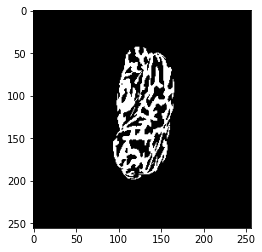

In [61]:
plt.imshow(x[:, :, 3], cmap='gray')

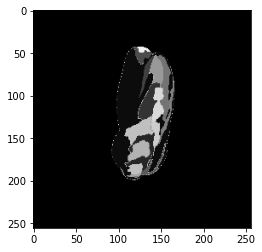

In [62]:
plt.imshow(y, cmap='gray')

In [ ]:
plotting.plot_